In [1]:
import numpy as np
import networkx as nx
from scipy.stats import multivariate_normal
import pandas as pd
import scipy.linalg as slin
import scipy.optimize as sopt
import warnings 
import torch as th
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from data_gen_ts import generate_structure,sem_generator
from tqdm import tqdm
from metrics import shd, classification_metrics, threshold_metrics
from data_gen_reg import gen_stationary_dyn_net_and_df_regime
from dynotears import from_pandas_dynamic,from_numpy_dynamic,dynotears_perso
from linear_utils import string_nodes, Dynotears

## Generate data:

In [2]:
from data_gen_reg import gen_stationary_dyn_net_and_df_regime
g_list,df_total, intra_nodes, inter_nodes = gen_stationary_dyn_net_and_df_regime(3,5,[300,200,500],1,4,1,w_max_inter=1,w_min_inter=0,
                                                                                 w_max_intra=1,w_min_intra=0,
                                                                                 graph_type_intra = "barabasi-albert",
                                                                                 graph_type_inter = "erdos-renyi",
                                                                                 max_data_gen_trials = 1000)

In [7]:
n_nodes = 5
lag = False
if lag == True:
            rearange_intra = [str(i)+"_lag0" for i in range(n_nodes)]
            rearange_inter1 = [str(i)+"_lag1" for i in range(n_nodes)]
            rearange_inter2 = [str(i)+"_lag2" for i in range(n_nodes)]
            rearange_inter = rearange_inter1 + rearange_inter2
else:
            rearange_intra = [str(i)+"_lag0" for i in range(n_nodes)]
            rearange_inter = [str(i)+"_lag1" for i in range(n_nodes)]

In [13]:
X_syn = df_total[rearange_intra].to_numpy()
X_lag_syn = df_total[rearange_inter].to_numpy()
data = pd.DataFrame(X_syn)

## CASTOR Linear:

In [14]:
class pi_tn(nn.Module):
            def __init__(self, regime):
                        super(pi_tn, self).__init__()
                        self.regime = regime
                        self.linear = nn.Linear(1,self.regime)
                        
            def forward(self,t):
                        outp = self.linear(t)
                        return outp

In [15]:
def train(num_epochs, model, data, gamma):
            model.train()
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            soft = nn.Softmax()
            for _ in range(num_epochs):
                        y_pre = model(data)  
                        loss = criterion(y_pre, gamma)
                        
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
            #print("loss: "+str(loss.item()))
            
            
            return soft(y_pre),loss.item(),model

In [16]:
def CASTOR(data,X,Xlags,max_it,lags, loss_thres,w_threshold,window):
            n = int(X.shape[1])
            nodes = string_nodes(data.columns)
            m = X.shape[0]
            N_regime = m//window
            L = np.zeros((lags*n, lags*n, N_regime))
            for it in range(max_it):
                        model_n = [Dynotears(nodes, sig_level=0.05, nlags=lags)  for _ in range(N_regime)]
                        graphss = [1 for i in range(N_regime)]
                        yl = np.zeros((m, n , N_regime))
                        if it == 0:
                                    p = np.zeros((m,N_regime))
                                    for c in range(N_regime):
                                                if c  == N_regime -1:
                                                            p[c*window:,c] = np.ones(m-c*window)
                                                            L[:, :, c] = model_n[c].infer_from_data(data,X[c*window:,:],Xlags[c*window:,:],w_threshold=w_threshold)
                                                            #graphss[c],L[:, :, c] = dynotears(data,X[c*window:,:],Xlags[c*window:,:], tau_max=2, alpha=0.0)

                                                else:
                                                            p[c*window:(c+1)*window,c] = np.ones(window)
                                                            L[:, :, c] = model_n[c].infer_from_data(data,X[c*window:(c+1)*window,:],Xlags[c*window:(c+1)*window,:],w_threshold=w_threshold)
                                                            #graphss[c],L[:, :, c] = dynotears(data,X[c*window:(c+1)*window,:],Xlags[c*window:(c+1)*window,:], tau_max=2, alpha=0.0)

                        else:
                                    for c in range(N_regime):
                                                gamma = gamma_hat[:,c].reshape((m,1))
                                                L[:, :, c] = model_n[c].infer_from_data(data,gamma*X,gamma*Xlags,w_threshold=w_threshold)
                                                #graphss[c],L[:, :, c] = dynotears(data,gamma*X,gamma*Xlags, tau_max=2, alpha=0.0)
                        pall = 0
                        gamma_hat = np.zeros((m, N_regime))
                        for class_idx in range(N_regime):
                                    #p[:,class_idx] = model(t)
                                    #yl[:, :, class_idx] = X[:,:n] - X[:,:n].dot(L[:n, :n, class_idx]) - X[:,n:lags*n].dot(L[n:lags*n,:n, class_idx])

                                    yl[:, :, class_idx] = X - X.dot(L[:n, :n, class_idx]) - Xlags.dot(L[n:lags*n,:n, class_idx])

                                    pall = pall + p[:,class_idx] * multivariate_normal.pdf(yl[:, :, class_idx], mean= np.zeros(n),
                                                                                    cov=1*np.eye(n))
                                    gamma_hat[:, class_idx] = p[:,class_idx] * multivariate_normal.pdf(yl[:, :, class_idx], mean= np.zeros(n),
                                                                                    cov=1*np.eye(n))
                        idx = np.argmax(gamma_hat/pall.reshape((m,1)), axis=-1)
                        gamma_hat = np.zeros( gamma_hat.shape )
                        gamma_hat[ np.arange(gamma_hat.shape[0]), idx] = 1

                        
                        if it>=0:
                                 aa = np.linspace(0,20*N_regime,X.shape[0]).reshape((X.shape[0],1))
                                 t = torch.tensor(aa)
                                 
                                 model = pi_tn(N_regime)
                                 
                                 p,loss,model_ = train(500,model, t.float(), torch.tensor(gamma_hat).float())
                                 #print("yes")
                                 p = p.detach().numpy()
                                 print(loss)
                                 if N_regime == 2:
                                             loss_thres = 0.8
                                 while loss>=loss_thres:
                                             p,loss,model_ = train(100,model_, t.float(), torch.tensor(gamma_hat).float())
                                             p = p.detach().numpy()
                                             #print(loss)
                                 gamma_sum = np.sum(gamma_hat, axis=0)
                                 gamma_sum[gamma_sum<40] = 0
                                 indexes, = np.where(gamma_sum!= 0)
                                 gamma_hat = gamma_hat[:,indexes]
                                 p = p[:,indexes]
                                 N_regime = len(indexes)
                                 print(str(np.sum(gamma_hat, axis=0))+" iter: "+str(it)+" , p: "+str(np.sum(p, axis=0)))
            return model_n,graphss,gamma_hat, L

In [17]:
import warnings
warnings.filterwarnings('ignore')
model_n,graphss,gamma_hat, L = CASTOR(data,X_syn,X_lag_syn,5,2,1,0.3,150)

4.559154510498047
[223. 150. 150.  77. 150. 250.] iter: 0 , p: [220.96577 138.68274 147.71251  75.7352  149.77142 267.13232]
0.7806634306907654
[545. 260. 191.] iter: 1 , p: [646.53595 151.93874 181.15701]
0.7682774066925049
[530. 288. 182.] iter: 2 , p: [682.48236 155.9029  161.6147 ]
10.124107360839844
[530. 293. 177.] iter: 3 , p: [650.17615  99.50281 250.32101]
3.936007022857666
[518. 292. 190.] iter: 4 , p: [572.2543  184.13382 243.61191]


## Causal graph plots:

In [19]:
gamma_hat

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [22]:
def plt_fig(reg,g_list,L, node):
            plt.figure(figsize=(18,10))
                        
            for i in range(reg):
                        
                        plt.subplot(2*reg,2,4*i+1)
                        L1 = L[:node,:node,i]
                        L1[L1<0.4] = 0
                        L1[L1>0.4] = 1
                        plt.imshow(L1)
                        plt.title("estimated instantaneous graph regime "+str(i+1))

                        plt.subplot(2*reg,2,4*i+2)
                        plt.imshow(nx.to_numpy_array(g_list[i])[node:2*node,node:2*node])
                        plt.title("True instantaneous link regime " +str(i+1))

                        plt.subplot(2*reg,2,4*i+3)
                        L1 = L[node:2*node,:node,i]
                        L1[L1<0.4] = 0
                        L1[L1>0.4] = 1
                        plt.imshow(L1)
                        plt.title("estimated second graph regime "+str(i+1))

                        plt.subplot(2*reg,2,4*i+4)
                        plt.imshow(nx.to_numpy_array(g_list[i])[:node,node:2*node])
                        plt.title("True Lag graph regime "+str(i+1))
            plt.tight_layout()

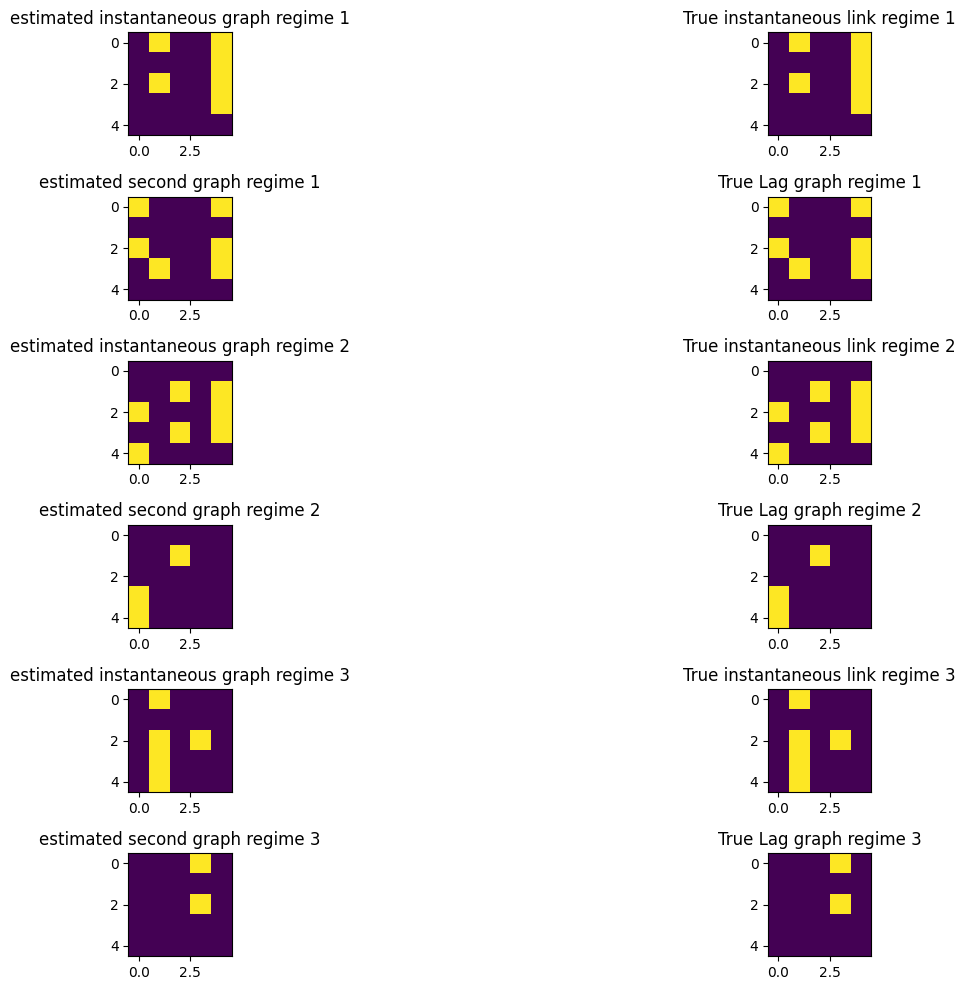

In [23]:
g_permuted = [g_list[2],g_list[0], g_list[1]]
plt_fig(3,g_permuted,L,5)